In [5]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import math
from golomb_code import encode, decode
import os

In [6]:
### data 1 compression - filtered data

In [7]:
file = '4b5c_filtered.edf'
data1 = mne.io.read_raw_edf(file)
data1.info

Extracting EDF parameters from /home/ifire/EEG/H-IoT-Golob-Rice-Compression-Automation/EEG data/4b5c_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Measurement date,"April 27, 2022 07:50:40 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,0.50 Hz
Lowpass,30.00 Hz


Setting up low-pass filter at 60 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 40 (effective, after forward-backward)
- Cutoff at 60.00 Hz: -6.02 dB

Using matplotlib as 2D backend.


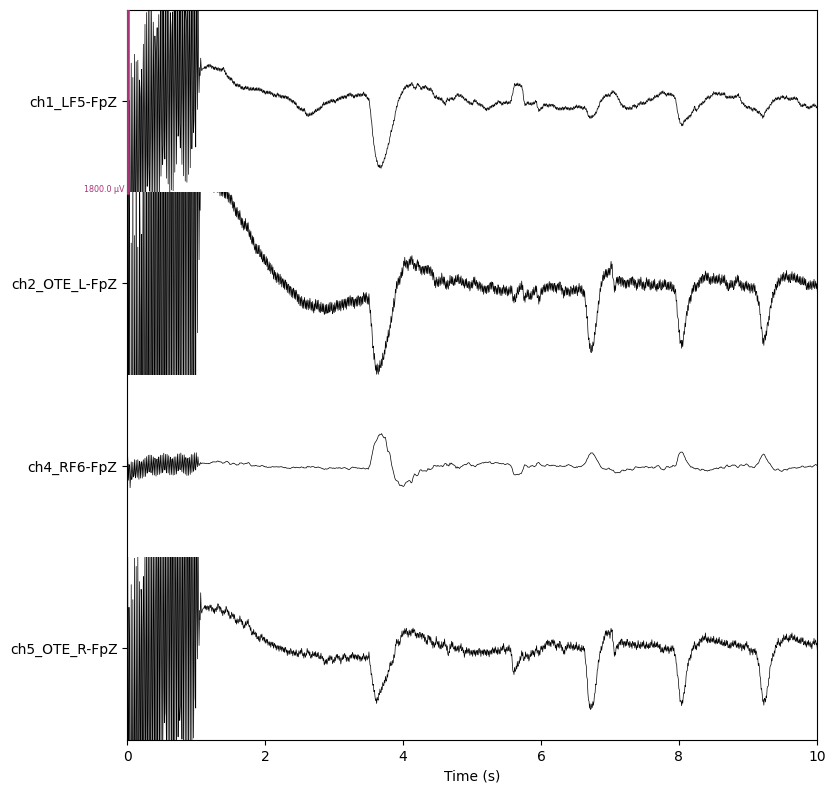

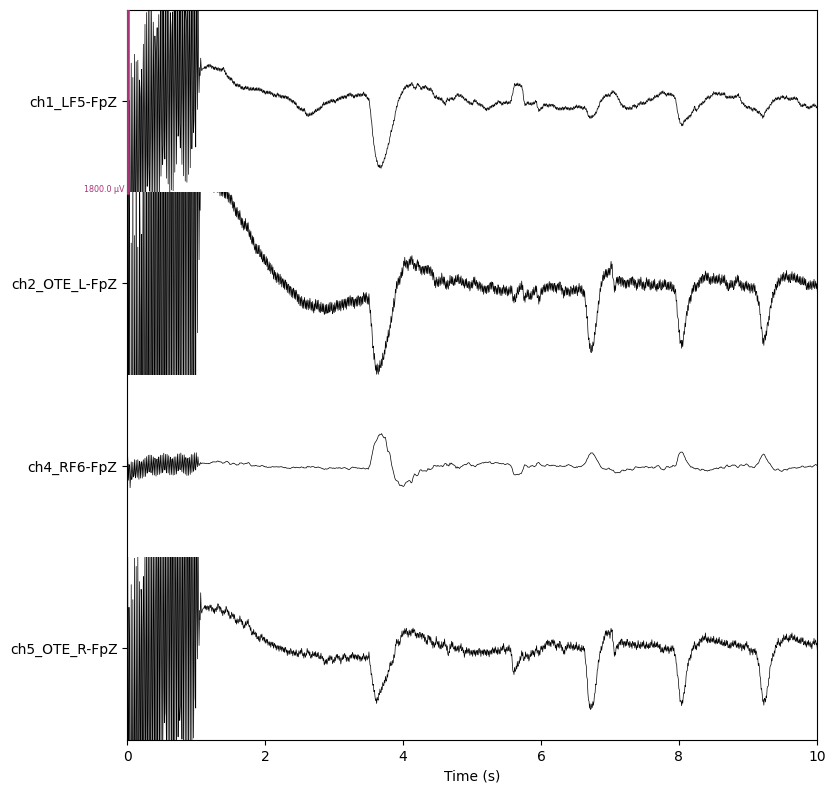

In [8]:
data1.plot( scalings='0.0009', clipping=0.5, remove_dc=True, lowpass =60, show_scrollbars=False, filtorder = 20, theme='auto')

In [10]:
EEG_raw_data  = data1.get_data()
SCALE=1e5 ## sclaed by 100000
raw_data= EEG_raw_data*SCALE

In [3]:
def non_neg_val(eeg_raw: np.ndarray)-> list:
    min_val = abs(eeg_raw.min())
    non_neg_val =[]
    for val in eeg_raw:
        val +=min_val
        non_neg_val.append(val)
    return non_neg_val
        

In [4]:
def parameter_estimation(non_neg_val: list) -> tuple:
    np_non_neg_val = np.array(non_neg_val)
    k_min = math.floor(math.log2((2/3) * (np_non_neg_val.mean()+ 1)))
    k_max = math.ceil(math.log2(np_non_neg_val.mean()))
    numerator  = math.log10( (math.sqrt(5)+1)/2 -1)
    denominator = math.log10(np_non_neg_val.mean() / (np_non_neg_val.mean()+1))
    k_geo  =  1 + math.floor(math.log2(numerator/denominator))
    
    return k_min, k_max, k_geo

In [13]:
test_1 = non_neg_val(raw_data[0])
parameter  = parameter_estimation(test_1)
parameter

(10, 12, 11)

In [ ]:
def compressed_file_size(data:list, parameter: str ) ->float:
    file_name = 'code_filter_words_channel_1_'+ parameter+'.txt'
    with open(file_name, 'w') as file:
            for val in data:
                file.write(val + "\n")
                

In [ ]:
def compression_ratio(data:np.ndarray, raw_file_size:float) -> float:
    non_neg_data =  non_neg_val(data)
    parameters = parameter_estimation(non_neg_data)
    
    non_neg_int_data = []
    for val in non_neg_data:
        non_neg_data.append(int(val))
    
    

In [42]:
import numpy as np
import math
import os

def compression_ratio(eeg_raw: np.ndarray, raw_file_size: float) -> None:
    min_val = abs(eeg_raw.min())
    non_neg_val = eeg_raw + min_val + 1
    
    np_non_neg_val = np.array(non_neg_val)
    k_min = math.floor(math.log2((2/3) * (np_non_neg_val.mean() + 1)))
    k_max = math.ceil(math.log2(np_non_neg_val.mean()))
    numerator = math.log10((math.sqrt(5) + 1) / 2 - 1)
    denominator = np.log10(np_non_neg_val.mean() / (np_non_neg_val.mean() + 1))
    k_geo = 1 + math.floor(math.log2(numerator / denominator))
    
    k_dict = {'k_min': k_min, 'k_max': k_max, 'k_geo': k_geo}
    
    non_neg_int_val = [int(val) for val in non_neg_val]
    print(k_dict)
    pass

    for x, y in k_dict.items():
        temp_code_words = [encode(val, y) for val in non_neg_int_val]  # Assuming encode is defined
        
        file_name = f'code_filter_words_channel_4_{x}.txt'
        with open(file_name, 'w') as file:
            for val in temp_code_words:
                file.write(val + "\n")
        temp_code_words = []
                
    for x in k_dict.keys():
        file_name = f'code_filter_words_channel_4_{x}.txt'
        file_size = os.path.getsize(file_name)
        print(f'the file size of the {x} is {file_size}')
        print(f'the compression ratio for {x} is {file_size / raw_file_size}')


In [7]:
raw_data[0]

array([  174.77105684,    49.08223615,  -157.36316982, ...,
       -1644.52908324, -1596.63678502, -1532.42619184])

In [8]:
with open('raw_fileter_channel_1.txt', 'w') as file:
    for val in raw_data[0]:
        file.write(str(val) + "\n")

## filetered compression 
channel 1

In [17]:
raw_channel_1_size = os.path.getsize('raw_fileter_channel_1.txt')
raw_channel_1_size 

2919851

In [23]:
raw_data[0].min()

-2590.003503135729

In [26]:
compression_ratio(raw_data[0], raw_channel_1_size)

{'k_min': 10, 'k_max': 12, 'k_geo': 11}
the file size of the k_min is 2140348
the compression ratio for k_min is 0.7330332951921177
the file size of the k_max is 2140323
the compression ratio for k_max is 0.7330247331113814
the file size of the k_geo is 2139968
the compression ratio for k_geo is 0.7329031515649257


channel 2

In [27]:
with open('raw_fileter_channel_2.txt', 'w') as file:
    for val in raw_data[1]:
        file.write(str(val) + "\n")

In [28]:
raw_channel_2_size = os.path.getsize('raw_fileter_channel_2.txt')
raw_channel_2_size 

2900280

In [31]:
compression_ratio(raw_data[1], raw_channel_1_size)

{'k_min': 10, 'k_max': 12, 'k_geo': 11}
the file size of the k_min is 2140341
the compression ratio for k_min is 0.7330308978095115
the file size of the k_max is 2140296
the compression ratio for k_max is 0.7330154860641862
the file size of the k_geo is 2139950
the compression ratio for k_geo is 0.7328969868667956


channel 3

In [32]:
with open('raw_fileter_channel_3.txt', 'w') as file:
    for val in raw_data[2]:
        file.write(str(val) + "\n")

In [33]:
raw_channel_3_size = os.path.getsize('raw_fileter_channel_3.txt')
raw_channel_3_size 

2968769

In [35]:
compression_ratio(raw_data[2], raw_channel_3_size)

{'k_min': 10, 'k_max': 12, 'k_geo': 11}
the file size of the k_min is 2140367
the compression ratio for k_min is 0.7209611121646716
the file size of the k_max is 2140328
the compression ratio for k_max is 0.7209479754066416
the file size of the k_geo is 2140004
the compression ratio for k_geo is 0.7208388392630076


channel 4

In [38]:
raw_data[3]

array([  288.03688487,    48.99690657,  -237.60792438, ...,
       -1643.88634726, -1595.94158366, -1531.73663081])

In [39]:
with open('raw_fileter_channel_last.txt', 'w') as file:
    for val in raw_data[3]:
        file.write(str(val) + "\n")

In [40]:
raw_channel_4_size = os.path.getsize('raw_fileter_channel_last.txt')
raw_channel_4_size 

2911998

In [43]:
compression_ratio(raw_data[3], raw_channel_4_size)

{'k_min': 10, 'k_max': 12, 'k_geo': 11}
the file size of the k_min is 2140350
the compression ratio for k_min is 0.7350108070129169
the file size of the k_max is 2140306
the compression ratio for k_max is 0.7349956971124293
the file size of the k_geo is 2139908
the compression ratio for k_geo is 0.7348590211943827


channel wise average